### Notebook explores some Classfication models with a small data set, the following classification will be perfomed 

* kNN 
* SVM 
* Naive Bayes

#### Data will be preprocessed to get cleaner data and following action will be preformed


#### import libraries required in notebook

In [1]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation 
from nltk.stem import PorterStemmer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from pickle import dump

#### Utility methods for Text-Preprocessing

In [2]:
# apply preprocessing to clean the corpus 
def applyPreprocessing(text) :
    
    #normalize the text 
    normalized_text = text.lower()
    
    #word tokenize
    tokens = word_tokenize(normalized_text)
    
    # Removing Numbers. as numbers do not add values in detection of spam or ham
    tokens = [token for token in tokens if not token.isnumeric()]
    
     #using PorterStemmer (other alternative SnowballStemmer, LancesterStemmer, RegexpStemmer)
    stemmer = PorterStemmer() 
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
        
     # Removing Punctuations and Special Characters
    filtered_tokens = [token for token in stemmed_tokens if token.isalnum()]
    
    #remove stop words
    stop_words = set(stopwords.words('english')) # Remove stopwords
    stopword_removed_tokens = [token for token in filtered_tokens if token.lower() not in stop_words]
    
    return ' '.join(stopword_removed_tokens)

#### Load the file and perform preprocessing and save the new preprocessed into a seperate column

In [3]:
# Load the file
df = pd.read_csv('files/smsspamcollection/SMSSpamCollection', delimiter='\t', header=None, names=['category', 'smstext'])

df['processed_smstext'] = df['smstext'].apply(applyPreprocessing)

# Convert the 'category' column to numeric representation
df['category_numeric'] = df['category'].astype('category').cat.codes
df

,category,smstext,processed_smstext,category_numeric
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail onli bugi n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...,1
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,0
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,thi 2nd time tri contact u pound prize claim e...,1
5568,ham,Will ü b going to esplanade fr home?,ü b go esplanad fr home,0
5569,ham,"Pity, * was in mood for that. So...any other s...",piti wa mood ani suggest,0
5570,ham,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy someth els nex...,0


#### Show the distribution of data to see how the ham/spam is distributed in the file

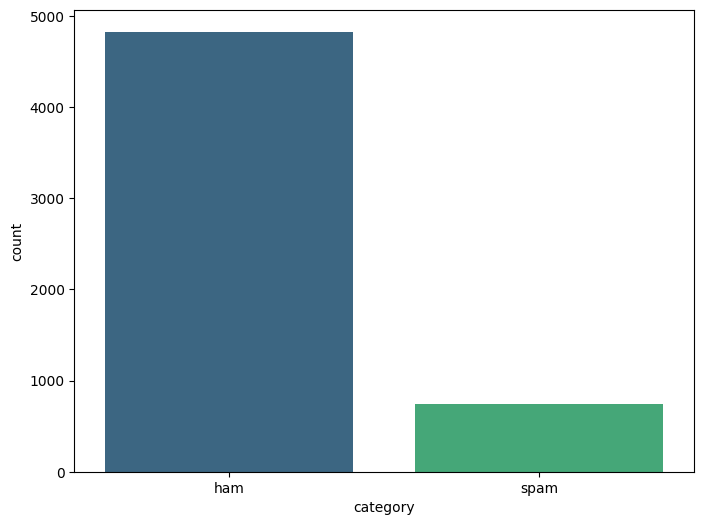

In [4]:
#sns to show the distributionl, the result is not good, need to get more spam dataset
plt.figure(figsize=(8,6))
sns.countplot(x='category', data=df, palette='viridis')
plt.show()

#### Use TFIDF vectorizer to vectorize the text data for processing in machine learning

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X = tfidf_vectorizer.fit_transform(df["processed_smstext"]) # this will be feature variable
y = df['category_numeric']  # target variable 

#this is a sparse vector and need to use SVD or PCA to convert this into dense vector and try with that dataset too, this will  done
#later
print(X.shape )
print(y.shape )

#dump the vectorizer for future use with unseen data
dump(tfidf_vectorizer,open('model/tfidf.pkl', 'wb'))

(5572, 6317)
(5572,)


#### Use kNN classifier to train and test the data, this will classify spam/ham, the data will be split with 70:30 ratio, in this 30 will be test data, the model will be saved for future use

#### usually the distribution should be 70:30 or 80:20 and using cross validation will give better result, but here i noticed , i was not getting right prediction , may be one reason could be my data set is not highly biased and it is having more ham then spam, so i reduced the test percentage

*************** Output the shape of data *******************
(3900, 6317)
(1672, 6317)
(3900,)
(1672,)
***************************************************************

Training Score = 1.0 ----------- Test Score = 0.930622009569378

accuracy score = 0.930622009569378


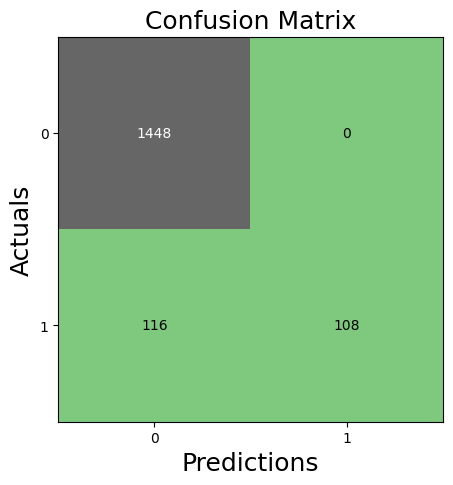

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

#changed the test to only 10% not a good approach, but will work with this later with a different dataset which has equal balance 
#in spam and ham
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = .3, shuffle = True, stratify = y,random_state = 3)

print('*************** Output the shape of data *******************')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print('***************************************************************')

#apply kNN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
knn.fit(X_train,y_train)

#check the score
print()
print(f"Training Score = {knn.score(X_train,y_train)} ----------- Test Score = {knn.score(X_test,y_test)}")
print()

y_predict = knn.predict(X_test)

#output accuracy score on the predicted data
acc_score = accuracy_score(y_test,y_predict)
print(f"accuracy score = {acc_score}")

#output a confusion matrix to find out the true positive and false postive
conf_matrix = confusion_matrix(y_test,y_predict)

#show the confusion matrix in a chart

ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(5, 5), cmap=plt.cm.Accent)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#save the knn model, this will be used for future prediction
dump(knn, open('model/knn_model.pkl', 'wb'))

###  Run a test for kNN Classifier with a new set of data and see how the model performs

In [36]:
from pickle import load

#text = "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
text = 'Winner!! life time opportunity fly free to Maldives, no ticket cost, hurry up call me to get this deal @897458221'

#load the tfid and knn from the pickle file 
tfidf_vectorizer = load(open('model/tfidf.pkl', 'rb'))
knn = load(open('model/knn_model.pkl', 'rb'))

processed_text = applyPreprocessing(text)

#vectorize the processed text
vec_data = tfidf_vectorizer.transform([processed_text])

#predict if this is spam or ham
y_predict = knn.predict(vec_data)

#category class
category_cls = {0:'ham',1:'spam'}
category_cls[y_predict[0]]

'ham'

### Use Naive Bayes to find spam/ham. lets see how this fair better then kNN

*************** Output the shape of data *******************
(3900, 6317)
(1672, 6317)
(3900,)
(1672,)
***************************************************************

Training Score = 0.9707692307692307 ----------- Test Score = 0.9581339712918661

accuracy score = 0.9581339712918661


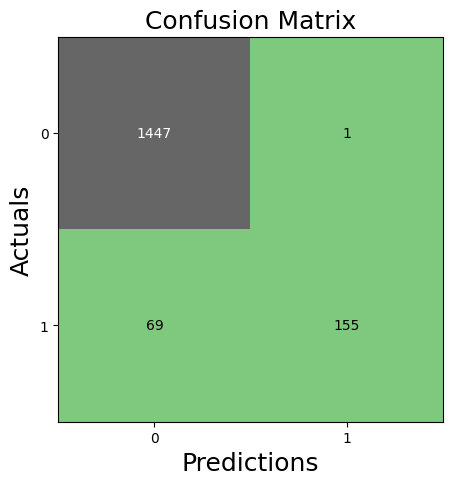

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix

#changed the test to only 10% not a good approach, but will work with this later with a different dataset which has equal balance 
#in spam and ham
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = .3, shuffle = True, stratify = y,random_state = 3)

print('*************** Output the shape of data *******************')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print('***************************************************************')

#apply multinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

#check the score
print()
print(f"Training Score = {mnb.score(X_train,y_train)} ----------- Test Score = {mnb.score(X_test,y_test)}")
print()

y_predict = mnb.predict(X_test)

#output accuracy score on the predicted data
acc_score = accuracy_score(y_test,y_predict)
print(f"accuracy score = {acc_score}")

#output a confusion matrix to find out the true positive and false postive
conf_matrix = confusion_matrix(y_test,y_predict)

#show the confusion matrix in a chart

ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(5, 5), cmap=plt.cm.Accent)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#save the knn model, this will be used for future prediction
dump(mnb, open('model/mnb_model.pkl', 'wb'))

### Run a test with Naive Bayes classifier with the model

In [26]:
from pickle import load

#text = "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
text = 'Winner!! You won free trip to Maldives hurry up call me to get this deal @897458221'

#load the tfid and knn from the pickle file 
tfidf_vectorizer = load(open('model/tfidf.pkl', 'rb'))
knn = load(open('model/mnb_model.pkl', 'rb'))

processed_text = applyPreprocessing(text)

#vectorize the processed text
vec_data = tfidf_vectorizer.transform([processed_text])

#predict if this is spam or ham
y_predict = knn.predict(vec_data)

#category class
category_cls = {0:'ham',1:'spam'}
category_cls[y_predict[0]]

'ham'

### Use SVM to find spam/ham. lets see how this fair better then kNN and Naive Bayes

*************** Output the shape of data *******************
(3900, 6317)
(1672, 6317)
(3900,)
(1672,)
***************************************************************

Training Score = 0.9964102564102564 ----------- Test Score = 0.9700956937799043

accuracy score = 0.9700956937799043


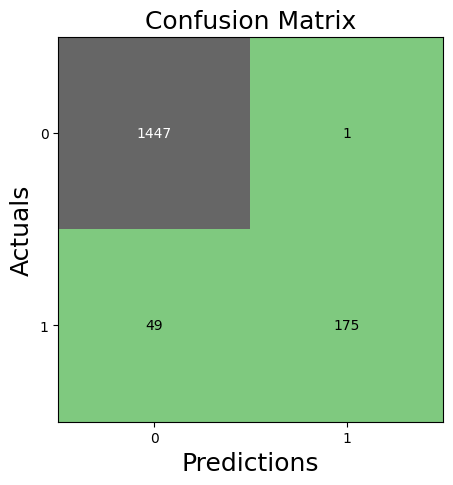

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix

#changed the test to only 10% not a good approach, but will work with this later with a different dataset which has equal balance 
#in spam and ham
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = .3, shuffle = True, stratify = y,random_state = 3)

print('*************** Output the shape of data *******************')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print('***************************************************************')

#apply multinomialNB classifier
svc = SVC()
svc.fit(X_train,y_train)

#check the score
print()
print(f"Training Score = {svc.score(X_train,y_train)} ----------- Test Score = {svc.score(X_test,y_test)}")
print()

y_predict = svc.predict(X_test)

#output accuracy score on the predicted data
acc_score = accuracy_score(y_test,y_predict)
print(f"accuracy score = {acc_score}")

#output a confusion matrix to find out the true positive and false postive
conf_matrix = confusion_matrix(y_test,y_predict)

#show the confusion matrix in a chart

ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(5, 5), cmap=plt.cm.Accent)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#save the knn model, this will be used for future prediction
dump(mnb, open('model/svc_model.pkl', 'wb'))

### Run a test with SVM classifier with the model

In [41]:
from pickle import load

#text = "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
text = 'WINNER!! You won free trip to Maldives hurry up call me to get this deal @897458221'

#load the tfid and knn from the pickle file 
tfidf_vectorizer = load(open('model/tfidf.pkl', 'rb'))
knn = load(open('model/svc_model.pkl', 'rb'))

processed_text = applyPreprocessing(text)

#vectorize the processed text
vec_data = tfidf_vectorizer.transform([processed_text])

#predict if this is spam or ham
y_predict = knn.predict(vec_data)

#category class
category_cls = {0:'ham',1:'spam'}
category_cls[y_predict[0]]

'ham'